In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import math
import statistics
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)


In [2]:
# Parameters for the exponential distribution
O1 = tf.constant(10.0, dtype=tf.float32)  # Adjust this value as needed
C1 = tf.constant(3.0, dtype=tf.float32)
Anoise = tf.constant(0.1, dtype=tf.float32)
Fnoise = tf.constant(0.1, dtype=tf.float32)
nE = tf.constant(10, dtype=tf.float32) #number of events
n = 1  # Number of channels

num_samples = 1000
dt = tf.constant(0.1, dtype=tf.float32)
T = tf.constant(200, dtype=tf.int32)  # In sample points :-)
#Must be a multiple of 2!!!

@tf.function
def sim_channel(params):
    nE, To, Tc, Anoise, Fnoise = params
    nE = tf.cast(nE, dtype=tf.int32)
    t = tf.range(0, T, dtype=tf.float32) * dt
    # Generate exponentially distributed random numbers
    exp_dist_o = tfp.distributions.Exponential(rate=1.0 / To)
    exp_dist_c = tfp.distributions.Exponential(rate=1.0 / Tc)
    
    num_events = T // 2  # Approximate number of events
    
    # Generate exponentially distributed random numbers
    num_events = T // 2  # Approximate number of events
    open_durations = exp_dist_o.sample(nE)
    zeros = tf.zeros(num_events-nE)
    open_durations = tf.concat([open_durations,zeros],axis=0)
    #tf.print(tf.shape(open_durations))
    #open_events = tf.cast(open_durations/dt, dtype=tf.int32)
    closed_durations = exp_dist_c.sample(nE)* tf.constant(-1, dtype=tf.float32) 
    closed_durations= tf.concat([closed_durations,zeros], axis=0)
    #closed_events = tf.cast(closed_durations/dt, dtype=tf.int32)
    
    # Interweave the two vectors
    interwoven_durations = [val for pair in zip(open_durations, closed_durations) for val in pair]
    #events = [int(val/dt) for val in interwoven_durations]
    # If you want to convert it back to a TensorFlow tensor
    #sequence = tf.convert_to_tensor(interwoven_durations)
    
    sequence = tf.convert_to_tensor(interwoven_durations)

    """
    # Apply durations to state
    time_indices = tf.searchsorted(cumulative_durations, t)
    state = tf.gather(state, time_indices)
    """

    
    # Add noise
    pink_noise = generate_pink_noise(T)*Fnoise
    white_noise = tf.random.normal(shape=[T])*Anoise
    noise = pink_noise+white_noise
    #sequence = Anoise*pink_noise + 0.01 * white_noise
    sequence = tf.cast(sequence, tf.float32)
    noise = tf.cast(noise, tf.float32)
   
    return tf.stack([sequence,noise],axis=1)


# Make sure generate_pink_noise is also differentiable
@tf.function
def generate_pink_noise(T):
    white_noise = tf.random.normal([T])
    
    # Compute the number of unique FFT coefficients
    num_fft_pts = T // 2 + 1
    
    # Generate the frequency spectrum
    f = tf.range(1, num_fft_pts, dtype=tf.float32)
    spectrum = 1.0 / tf.sqrt(f)
    spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
    
    # Compute FFT of white noise
    white_noise_fft = tf.signal.rfft(white_noise)
    
    # Apply pink noise spectrum
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    
    # Inverse FFT to get pink noise in time domain
    pink_noise = tf.signal.irfft(pink_noise_fft)
    
    # Normalize
    return pink_noise / tf.math.reduce_std(pink_noise)

# Generate training data
"""training_data = []
lens=[]
for sample in tqdm(range(num_samples)):   
    params = tf.stack([nE, O1, C1, Anoise, Fnoise])  # Use tf.stack instead of tf.constant
    segment = sim_channel(params)
    lens.append(sum(abs(segment)))
    training_data.append(segment)
print(f"Average duration was {sum(lens)/len(lens)}")"""

def make_data(file_path):
    #This file looks like it changes a bit so just get start
    df = df = pd.read_csv(file_path, header=None, names=["Raw", "Channels"])
    closedNoise = df.loc[df["Channels"] == 0, "Raw"]
    openNoise = df.loc[df["Channels"] == 1, "Raw"]
    closedNoise=closedNoise-closedNoise.mean()
    openNoise=openNoise-openNoise.mean()
    combinedNoise = pd.concat([closedNoise, openNoise], axis=0).reset_index(drop=True)
    # Identify where the value changes
    df['Change'] = df['Channels'].ne(df['Channels'].shift()).cumsum()
    # Group by the change and calculate the length of each sequence
    sequence_lengths = df.groupby('Change').size().reset_index(name='Length')
    # Extract the sequences
    sequences = df.groupby('Change')['Channels'].first().reset_index(name='Sequence')
    
    # Merge the sequences and their lengths
    result = pd.merge(sequences, sequence_lengths, on='Change').drop(columns='Change')
    
    # Assign negative lengths to sequences of 0s and positive lengths to sequences of 1s
    result['Length'] = result.apply(lambda row: -row['Length'] if row['Sequence'] == 0 else row['Length'], axis=1)
    
    # Extract the lengths as a list
    sequence_lengths = result['Length'].tolist()

    zeros = tf.zeros(len(combinedNoise)-len(sequence_lengths))
    sequence_lengths = tf.concat([sequence_lengths,zeros],axis=0)
    data = np.stack([sequence_lengths, combinedNoise], axis=1)
    data = tf.convert_to_tensor(data)
    return data

file_path = "/Users/rbj/Documents/GitHub/DeepGANnel/Lina2/4096lina11raw.csv"
training_data =  make_data(file_path)  
print(training_data.shape)
training_data = training_data[:275,:]
len(training_data)
training_data = tf.reshape(training_data, shape=(-1,25,2))


(150752, 2)


2024-08-28 22:05:32.892544: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-28 22:05:32.892563: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-28 22:05:32.892568: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-28 22:05:32.892581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-28 22:05:32.892592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#Now as a function
def prep_plot(data):
    data = np.asarray(data)
    events = data[0,:,0]
    sequence=[]
    for val in events.tolist():
        if val >= 0:
            sequence.extend([1]*int(val) )
        else:
            sequence.extend([0]*int(abs(val)) )
    #Now get the noise
    noise = data[:,:,1].reshape(-1,)
    if len(noise) < len(sequence):
        # Repeat noise to match the length of sequence
        repeats = tf.math.ceil(tf.shape(sequence)[0] / tf.shape(noise)[0])
        repeated_noise = tf.tile(noise, [tf.cast(repeats, tf.int32)])
        noise = repeated_noise[:tf.shape(sequence)[0]]  # Trim to match the exact length

    sim_raw = sequence+noise[:len(sequence)]
    return sim_raw
    


def funky_plot(plt_data):
    #plt_data is a list of datas, so if only one plot use [data]
    #Now just default titles. Posh up if needs changing
    titles = ["Generated", "Training"]
    if len(plt_data) == 1:
        fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    else:
        fig, axs = plt.subplots(len(plt_data), 1, figsize=(10, 6))
    for i, data in enumerate(plt_data):
        axs[i].plot(data)
        axs[i].set_title(titles[i])
        plt.show


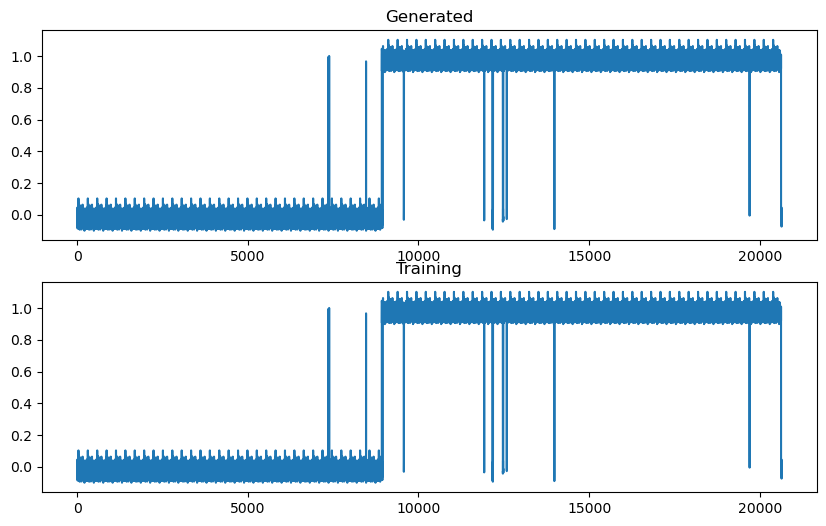

In [4]:
sim_raw = prep_plot(training_data)
funky_plot([sim_raw,sim_raw])

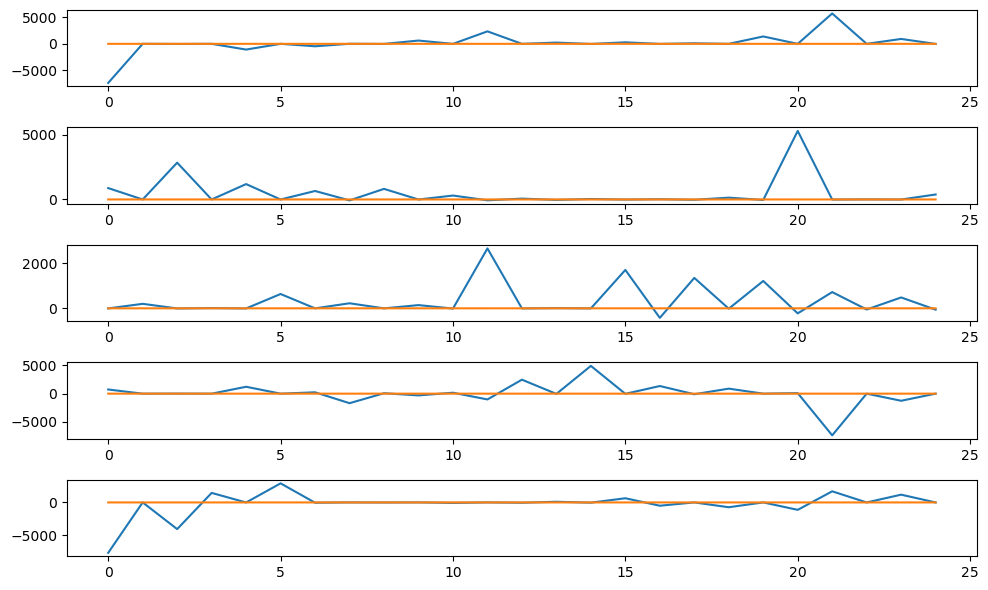

In [5]:
# Create a figure with two subplots (panels)
fig, axs = plt.subplots(5, 1, figsize=(10, 6))
for i in range(5):
    axs[i].plot(training_data[i] )
    #axs[i].set_ylim([-200,200])
plt.tight_layout()
plt.show()


In [6]:
# Define the generator model

def make_generator_model():
    noise_input = tf.keras.layers.Input(shape=(100,))
    x = tf.keras.layers.Dense(128, activation='relu')(noise_input)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer without activation
    raw_output = tf.keras.layers.Dense(5)(x)
    
    # Apply appropriate activations/scaling to each output
    nE = tf.keras.layers.Lambda(lambda x: tf.round(tf.abs(x)) + 1)(raw_output[:, 0:1])  # Positive, non-zero
    To= tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 0.1)(raw_output[:, 1:2])  # Positive, non-zero
    Tc = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 0.1)(raw_output[:, 2:3])  # Positive, non-zero
    #phase = tf.keras.layers.Lambda(lambda x: x * 2 * np.pi)(raw_output[:, 2:3])  # Any value, scaled to [0, 2π]
    Anoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 3:4])  # Positive
    Fnoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 4:5])  # Positive  
    output = tf.keras.layers.Concatenate()([nE, To, Tc, Anoise, Fnoise])
    #output = tf.keras.layers.Concatenate()([To, Tc])
    output = tf.keras.layers.Lambda(lambda x: x * 10)(output)  # Multiply by 10
    
    return tf.keras.Model(inputs=noise_input, outputs=output)


# Define the discriminator model batch, record len, channels = events then noise
num_points = T.numpy().item()
def make_discriminator_model():
    input_shape = (num_points,2) 
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((num_points, 2))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    # Dense layers
    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu')(x)"""
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True))

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [7]:
# Training step
@tf.function
def train_step(real_data):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_params = generator(noise, training=True)
        #tf.print("generated_params:", generated_params[0])
        
        generated_data = tf.map_fn(sim_channel, generated_params, fn_output_signature=tf.float32)
        #tf.print("generated_data shape:", tf.shape(generated_data))
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        #tf.print("real_output:", real_output[0])
        #tf.print("fake_output:", fake_output[0])
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #tf.print("gen_loss:", gen_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    tf.print("steps per epoch", steps_per_epoch)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        
        for step, batch in tqdm(enumerate(dataset), total=steps_per_epoch):
            #clear_output(wait=True)
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss = train_step(batch)
                #tf.print("gen_loss",gen_loss)
                epoch_gen_loss += gen_loss
                #tf.print("epoch_gen_loss",gen_loss)
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break

        #tf.print("epoch_gen_loss",epoch_gen_loss)
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch
        clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.8f}, "
              f"Discriminator Loss: {avg_disc_loss:.8f}")
        
        # Generate and plot sine waves
        egs=5
        
        # Generate and plot sine waves
        EgNoise = tf.random.normal([egs, 100])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        #print(steps_per_epoch)
        print("params", generated_params[0])
       
        gen_waves=[]
        for i in range(egs):
            gen_waves.append( sim_channel(generated_params[i]) )

        """
        # Create a figure with two subplots (panels)
        fig, axs = plt.subplots(egs, 1, figsize=(10, 6))
        for i in range(egs):
            axs[i].plot(gen_waves[i] )
            #axs[i].set_ylim([0,1])
        plt.tight_layout()
        """
        #tf.print(tf.shape(gen_waves))
        raw1 = prep_plot(gen_waves)
        raw2 = prep_plot(training_data)
        funky_plot([raw1,raw2])

        plt.show()
              
        if (epoch + 1) % 10 == 0:
            print(f"Completed {epoch + 1} epochs")
            plt.savefig(f"chanFigs/fig{epoch}.png")


In [8]:
batch_size = 10
training_dataset = tf.data.Dataset.from_tensor_slices(
    training_data).shuffle(num_samples).batch(batch_size, drop_remainder=True).repeat()


Epoch 31/20000 - Generator Loss: 0.00000000, Discriminator Loss: 0.00000000
params tf.Tensor([10.         6.3014355  6.88323    1.9754729  5.333029 ], shape=(5,), dtype=float32)


<Figure size 640x480 with 0 Axes>

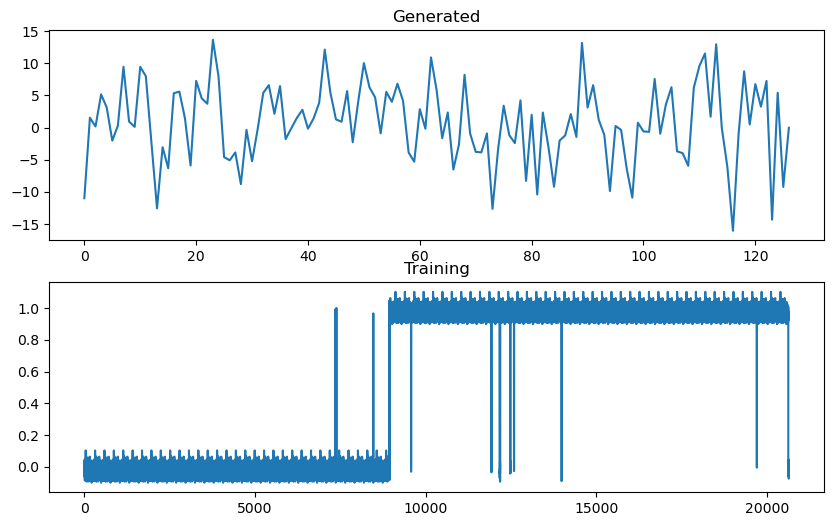

Epoch 32/20000


  0%|                                                                                                  | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [9]:
epochs=20000
train(training_dataset, epochs)

In [ ]:
num_samples=1000